In [2]:
from IPython.core.display import display, HTML
display(HTML(
    '<style>'
        '.jp-Notebook { padding-left: 0% !important; padding-right: 0% !important; width:100% !important; } '
    '</style>'
))

import pandas as pd
import numpy as np
import os
import re

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%matplotlib widget

matplotlib.style.use("bmh")
font = {'size': 13}
matplotlib.rc('font', **font)

from IPython.display import display

%load_ext autoreload
%autoreload 2
    
import v0_2_0

/tmp/ipykernel_505880/2699245673.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
COLLECT_TS = "2024-08-06T07:50:39.470480264+00:00"
TARGET_PID = 94328
TARGET_METRIC = "delay_ms"
PATH = "figures/ml-inference"
FIGSIZE = (3.2, 3)
os.makedirs(PATH, exist_ok=True)

# Target

In [4]:
user = pd.read_csv(f"../data/{COLLECT_TS}/application-metrics/data/raw_users.csv")
user = user.sort_values(by="epoch_s")
target = pd.read_csv(f"../data/{COLLECT_TS}/application-metrics/data/percentile_95.csv")
target = target.sort_values(by="epoch_s")
MIN_TIMESTAMP, MAX_TIMESTAMP = target["epoch_s"].min(), target["epoch_s"].max()

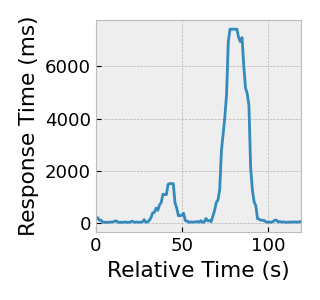

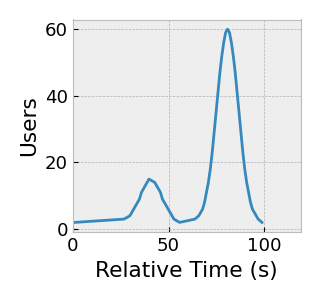

In [10]:
XLIM = [0, MAX_TIMESTAMP - MIN_TIMESTAMP]

plt.figure(figsize=FIGSIZE)
plt.plot(target["epoch_s"] - MIN_TIMESTAMP, target["delay_ms"])
plt.xlabel("Relative Time (s)")
plt.ylabel("Response Time (ms)")
plt.xlim(XLIM)
plt.tight_layout()
plt.savefig(f"{PATH}/response_time.pdf", bbox_inches='tight', pad_inches=0)
plt.show()

plt.figure(figsize=FIGSIZE)
plt.plot(user["epoch_s"] - MIN_TIMESTAMP, user["user_count"])
plt.xlabel("Relative Time (s)")
plt.ylabel("Users")
plt.xlim(XLIM)
plt.tight_layout()
plt.savefig(f"{PATH}/users.pdf", bbox_inches='tight', pad_inches=0)
plt.show()


# Sched

In [ ]:
XLIM, YLIM = [0, MAX_TIMESTAMP - MIN_TIMESTAMP], [0, 1.02]
START_TIMESTAMP = MIN_TIMESTAMP + XLIM[0]
END_TIMESTAMP = MIN_TIMESTAMP + XLIM[1]

metric_files = v0_2_0.recursive_dfs(f"../data/{COLLECT_TS}/system-metrics/thread/{TARGET_PID}")
metric_files = pd.Series(filter(lambda s: 'sched/' in s, metric_files))
metrics = v0_2_0.metric_files_to_df(metric_files, epoch_interval_s=(int(MIN_TIMESTAMP), int(MAX_TIMESTAMP)))

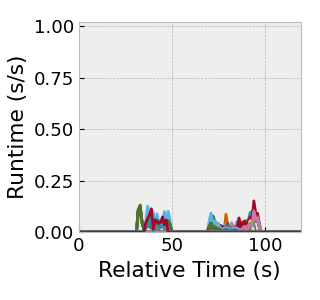

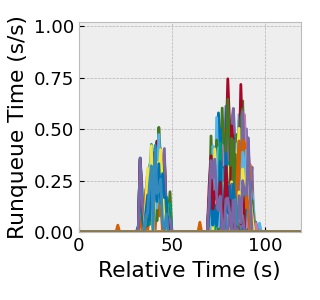

In [14]:
plt.close('all')

# Sched Runtime

col_filter = metrics.columns[metrics.columns.str.contains("runtime_rate")].append(pd.Index(["epoch_s"]))
sched = metrics.loc[:, col_filter]
sched = pd.merge(sched, target.loc[:, ["epoch_s", TARGET_METRIC]], on="epoch_s", how="outer")
sched = sched.loc[(sched["epoch_s"] > START_TIMESTAMP) & (sched["epoch_s"] < END_TIMESTAMP), :]
corr = sched.corr()[TARGET_METRIC]
corr = corr.sort_values(ascending=False)
significant_corr = corr#[(corr > 0.5) | (corr < -0.5)]

plt.figure(figsize=FIGSIZE)

plt.ylabel("Runtime (s/s)")
plt.xlabel("Relative Time (s)")
threads = pd.Index([])
for col in significant_corr.index: 
    if "epoch_s" in col or TARGET_METRIC in col or "epoch_ms" in col: 
        continue
    if metrics[col].max() < 0.02: 
        continue
    threads = threads.append(pd.Index([col]))
    thread = re.sub(r"thread/\d+/(\d+)/.*", r"\1", col)
    plt.plot(metrics["epoch_s"] - MIN_TIMESTAMP, metrics[col], label=thread)
plt.xlim(XLIM)
plt.ylim(YLIM)
plt.tight_layout()
plt.savefig(f"{PATH}/runtime.pdf", bbox_inches='tight', pad_inches=0)
plt.show()

runtime_threads = threads

# Sched Runqueue

col_filter = metrics.columns[metrics.columns.str.contains("rq_time_rate")].append(pd.Index(["epoch_s"]))
sched = metrics.loc[:, col_filter]
sched = pd.merge(sched, target.loc[:, ["epoch_s", TARGET_METRIC]], on="epoch_s", how="outer")
sched = sched.loc[(sched["epoch_s"] > START_TIMESTAMP) & (sched["epoch_s"] < END_TIMESTAMP), :]
corr = sched.corr()[TARGET_METRIC]
corr = corr.sort_values(ascending=False)
significant_corr = corr#[(corr > 0.5) | (corr < -0.5)]

plt.figure(figsize=FIGSIZE)
plt.ylabel("Runqueue Time (s/s)")
plt.xlabel("Relative Time (s)")
threads = pd.Index([])
for col in significant_corr.index: 
    if "epoch_s" in col or TARGET_METRIC in col or "epoch_ms" in col: 
        continue
    threads = threads.append(pd.Index([col]))
    plt.plot(metrics["epoch_s"] - MIN_TIMESTAMP, metrics[col])
plt.xlim(XLIM)
plt.ylim(YLIM)
plt.tight_layout()
plt.savefig(f"{PATH}/runqueue_time.pdf", bbox_inches='tight', pad_inches=0)
plt.show()

rq_threads = threads

**Observations**

1. Both periods during which the target metric suffers degradation, there is significant runtime and runqueue wait time activity.

## IPC

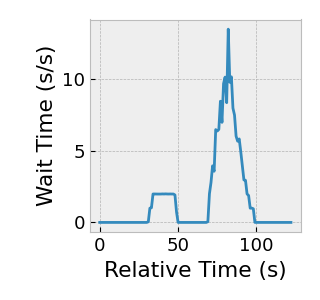

In [21]:
HOST = "172.25.0.3"

plt.close("all")

metric_files = v0_2_0.recursive_dfs(f"../data/{COLLECT_TS}/system-metrics/global/epoll")
metric_files = pd.Series(filter(lambda s: HOST in s, metric_files))
metrics = v0_2_0.metric_files_to_df(metric_files, epoch_interval_s=(MIN_TIMESTAMP, MAX_TIMESTAMP))
col_filter = metrics.columns[metrics.columns.str.contains("wait_rate")]
metrics = metrics.loc[:, col_filter.append(pd.Index(["epoch_s"]))]

epolls = metrics.columns.str.replace(r".*/epoll/(.*?)/.*", r"\1", regex=True).unique()
epolls = epolls[epolls != "epoch_s"]

for epoll in epolls: 
    if epoll != "ffff9e634de4ab40": 
        continue
    plt.figure(figsize=FIGSIZE)
    plt.ylabel("Wait Time (s/s)")
    plt.xlabel("Relative Time (s)")
    col_filter = metrics.columns[metrics.columns.str.contains(f"{epoll}")]
    res = pd.Series(dtype="Float64")
    res.name = "value"
    for col in col_filter:
        sub = metrics.loc[:, ["epoch_s", col]].set_index("epoch_s")
        sub.columns = ["value"]
        res = res.add(sub["value"], fill_value=0)
        host, = re.search("ipv4.+?_(.*?)/", col).groups()
        # plt.plot(metrics["epoch_s"] - MIN_TIMESTAMP, metrics[col], label=host)
    res = res.reset_index()
    plt.plot(res["epoch_s"] - MIN_TIMESTAMP, res["value"], label="total")
    plt.tight_layout()
    plt.savefig(f"{PATH}/external_wait_time.pdf", bbox_inches='tight', pad_inches=0)
    plt.show()

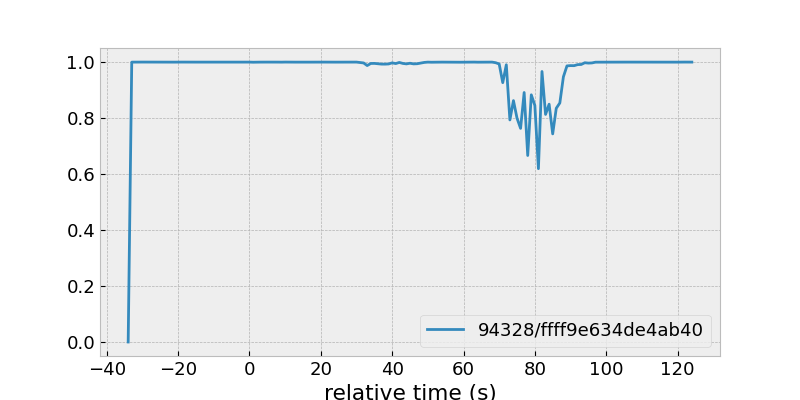

In [25]:
metric_files = v0_2_0.recursive_dfs(f"../data/{COLLECT_TS}/system-metrics/thread/{TARGET_PID}")
metric_files = pd.Series(filter(lambda s: 'epoll' in s, metric_files))
metrics = v0_2_0.metric_files_to_df(metric_files, epoch_interval_s=(MIN_TIMESTAMP, MAX_TIMESTAMP))
col_filter = metrics.columns[metrics.columns.str.contains("|".join(epolls))]
col_filter = col_filter[col_filter.str.contains("_rate")]
metrics = metrics.loc[:, col_filter.append(pd.Index(["epoch_s"]))]

plt.figure(figsize=(8, 4))
plt.xlabel("relative time (s)")
for col in metrics.columns:
    if col == "epoch_s":
        continue
    epoll = re.sub(r".*/(.*?)/ipc/streams/epoll_(.*)/.*", r"\1/\2", col)
    plt.plot(metrics["epoch_s"] - MIN_TIMESTAMP, metrics[col], label=epoll)
plt.legend()
plt.show()

**Observations**

1. Target process 94328 waits for epoll ...ab40, which in turn shows no client connections outside of the degradation periods. 

# Futex

We now try to determine how the workload is spreading to the other threads. As such, we first analyse which futex addresses the thread waiting for the epoll resources is waking up.

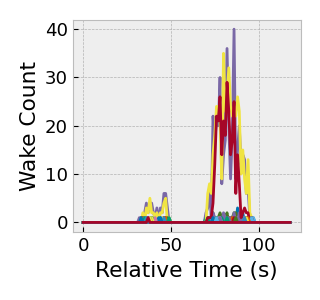

In [27]:
plt.close('all')

futex_address = set()

files = v0_2_0.recursive_dfs(f"../data/{COLLECT_TS}/system-metrics/thread/{TARGET_PID}/{TARGET_PID}")
files = pd.Series(filter(lambda s: 'futex/wake' in s, files))

futexes = files.str.replace(r".*/([\w-]+).csv$", r"\1", regex=True).unique()

plt.figure(figsize=FIGSIZE)
plt.ylabel("Wake Count")
plt.xlabel("Relative Time (s)")
for futex in futexes:
    futex_files = files[files.str.contains(f"/{futex}.csv")]
    metrics = v0_2_0.metric_files_to_df(futex_files, epoch_interval_s=(int(MIN_TIMESTAMP), int(MAX_TIMESTAMP)))
    col_filter = metrics.columns[metrics.columns.str.contains("futex_count")]
    for col in col_filter:
        futex_address.add(futex)
        plt.plot(metrics["epoch_s"] - MIN_TIMESTAMP, metrics[col], label=f"{futex}")
plt.tight_layout()
plt.savefig(f"{PATH}/futex_wake_count.pdf", bbox_inches='tight', pad_inches=0)
plt.show()

We now want to determine which of these futex addresses are not being waited for by the same thread waiting for the epoll resource.

In [28]:
files = v0_2_0.recursive_dfs(f"../data/{COLLECT_TS}/system-metrics/thread/{TARGET_PID}/{TARGET_PID}")
files = pd.Series(filter(lambda s: 'futex/wait' in s, files))

futexes = files.str.replace(r".*/([\w-]+).csv$", r"\1", regex=True).unique()
for futex in futexes: 
    if futex not in futex_address:
        continue
    futex_address.remove(futex)

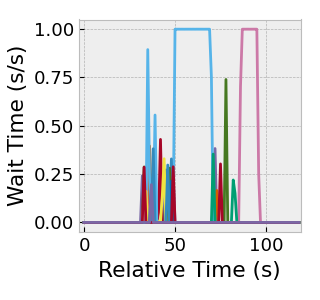

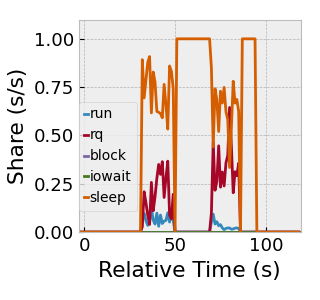

In [70]:
XLIM = [-3, MAX_TIMESTAMP - MIN_TIMESTAMP]

files = v0_2_0.recursive_dfs(f"../data/{COLLECT_TS}/system-metrics/thread/{TARGET_PID}")
files = pd.Series(filter(lambda s: 'futex/wait' in s, files))

plt.close("all")


wait_futex_threads = {}

threads = files.str.replace(r".*/thread/\d+/(\d+)/.*", r"\1", regex=True).unique()

for thread in threads[:10]:
    if thread != "101439":
        continue
        
    thread_files = files[files.str.contains(f"thread/.*/{thread}/.*")]
    futex_files = thread_files[thread_files.str.contains("|".join(futex_address))]
    if len(futex_files) == 0: 
        continue
    
    plt.figure(figsize=FIGSIZE)
    plt.ylabel("Wait Time (s/s)")
    plt.xlabel("Relative Time (s)")
    metrics = v0_2_0.metric_files_to_df(futex_files, epoch_interval_s=(int(MIN_TIMESTAMP), int(MAX_TIMESTAMP)))
    col_filter = metrics.columns[metrics.columns.str.contains("_rate")]
    for col in col_filter:
        futex, = re.search(r"wait/(.*?)/", col).groups()
        thread_list = wait_futex_threads.get(futex)
        if thread_list == None: 
            thread_list = list()
            wait_futex_threads[futex] = thread_list
        thread_list.append(thread)
        
        plt.plot(metrics["epoch_s"] - MIN_TIMESTAMP, metrics[col], label=f"{futex}")
    # plt.legend()
    plt.xlim(XLIM)
    plt.tight_layout()
    plt.savefig(f"{PATH}/thread_futex_wait.pdf", bbox_inches='tight', pad_inches=0)
    plt.show()

    metric_files = v0_2_0.recursive_dfs(f"../data/{COLLECT_TS}/system-metrics/thread/{TARGET_PID}/{thread}")
    metric_files = pd.Series(filter(lambda s: 'sched/' in s, metric_files))
    
    plt.figure(figsize=FIGSIZE)
    plt.ylabel("Share (s/s)")
    plt.xlabel("Relative Time (s)")
    metrics = v0_2_0.metric_files_to_df(metric_files, epoch_interval_s=(int(MIN_TIMESTAMP), int(MAX_TIMESTAMP)))
    rate_filter = metrics.columns[metrics.columns.str.contains("_rate")].append(pd.Index(["epoch_s"]))
    metrics = metrics.loc[:, rate_filter]
    metrics["awake"] = metrics["thread/94328/101439/sched/sleep_time_rate"] > 0
    metrics["thread/94328/101439/sched/derived_sleep_time_rate"] = 1 - (metrics["thread/94328/101439/sched/runtime_rate"] + metrics["thread/94328/101439/sched/rq_time_rate"] + metrics["thread/94328/101439/sched/block_time_rate"])
    metrics["thread/94328/101439/sched/derived_sleep_time_rate"] = metrics["thread/94328/101439/sched/derived_sleep_time_rate"] * metrics["awake"]
    metrics = metrics.drop(["awake", "thread/94328/101439/sched/sleep_time_rate"], axis=1)
    metrics = metrics.rename(columns={"thread/94328/101439/sched/derived_sleep_time_rate": "thread/94328/101439/sched/sleep_time_rate"})
    for col in metrics.columns:
        if col == "epoch_s": 
            continue
        rate_metric, = re.search(r"/(.\w+?)_*time_rate", col).groups()
        plt.plot(metrics["epoch_s"] - MIN_TIMESTAMP, metrics[col], label=rate_metric)
    plt.legend(loc=(0, 0.1), prop={"size": 10}, handletextpad=0.1, columnspacing=0.5, handlelength=0.3)
    plt.xlim(XLIM)
    plt.ylim([0, 1.1])
    plt.tight_layout()
    plt.savefig(f"{PATH}/thread_sched_stats.pdf", bbox_inches='tight', pad_inches=0)
    plt.show()

**Observations**

1. Each threads waits for a speicific set of futex addresses.
2. During its lifetime, the time during which the thread presents futex wait activity also coincides with the time the thread presents scheduling activity.
3. When there is no more futex activity and no more scheduling activity, these threads are decomissioned.
4. 
5. Some of these threads are very shortlived and function only on high demand (103438), and other threads persist between degradation periods (101439).
6. While there are no requests, thread 101439 shows it spends its time waiting for a futex resource.